In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.utils import isWeekend, calculate_depth

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import plot_tree

import shap
shap.initjs()

c:\Users\Acer\anaconda3\envs\angusta\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read Data

In [2]:
tasks = pd.read_csv('data/task_report_30_4.csv')
task_detail = pd.read_csv('data/task_30.csv')
projects = pd.read_csv('data/project_report_30_4.csv')

# Convert to datetime
tasks['Date'] = pd.to_datetime(tasks['Date'])
tasks['StartDate'] = pd.to_datetime(tasks['StartDate'])
tasks['EndDate'] = pd.to_datetime(tasks['EndDate'])
tasks['ActualStartDate'] = pd.to_datetime(tasks['ActualStartDate'])
tasks['ActualEndDate'] = pd.to_datetime(tasks['ActualEndDate'])

## Exploratory Data Analysis

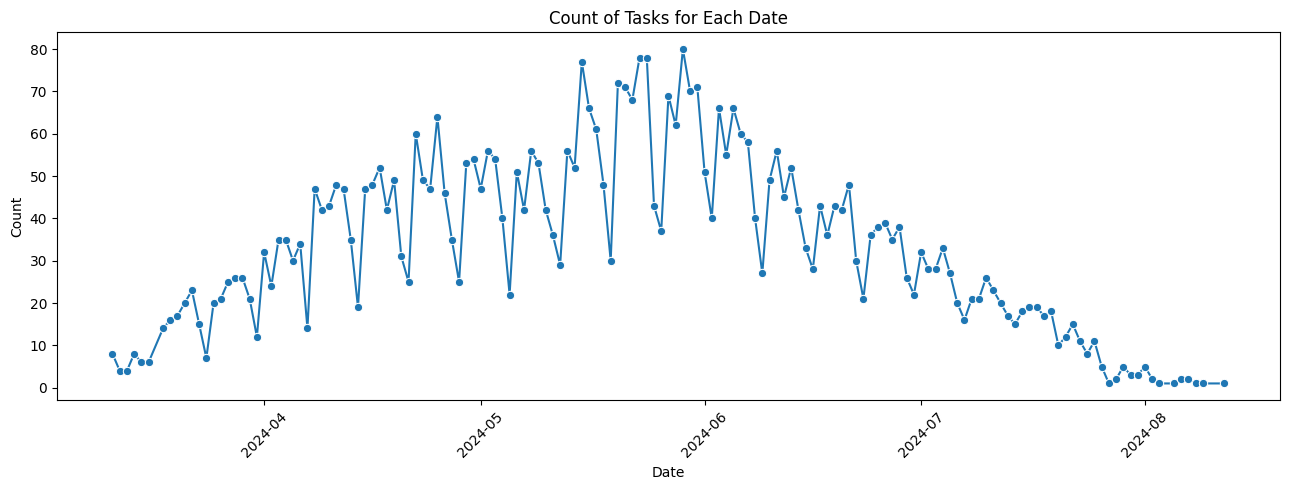

In [3]:
date_counts = tasks.groupby(['Date']).size().reset_index(name='Count')

# Plotting with Seaborn
plt.figure(figsize=(13, 5))
sns.lineplot(data=date_counts, x='Date', y='Count', marker='o')
plt.title('Count of Tasks for Each Date')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [4]:
project_counts = tasks.groupby(['ProjectID','ID']).size().reset_index(name='Count')
project_counts = project_counts.groupby('ProjectID').agg({'ID':'count','Count':'sum'}).reset_index()
project_counts = project_counts.astype(int)
project_counts['AvgDaysPerTask'] = (project_counts['Count'] / project_counts['ID']).round(2)

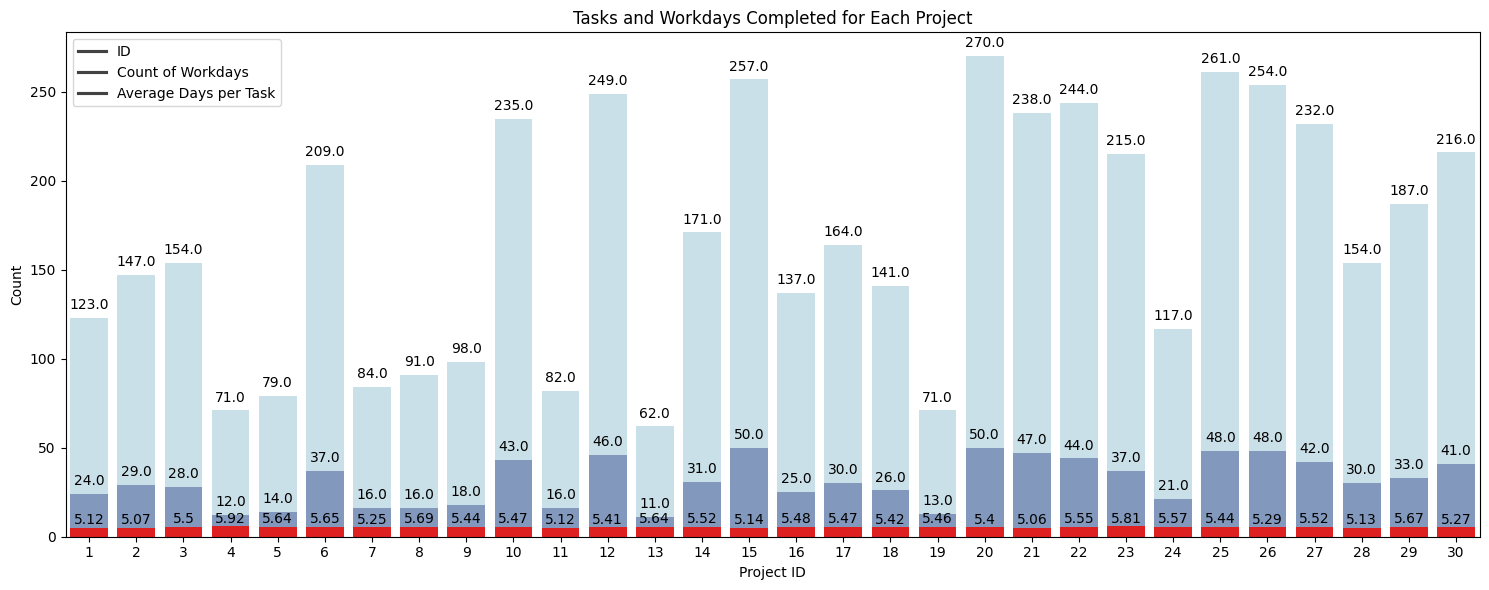

In [5]:
plt.figure(figsize=(15, 6))
sns.barplot(data=project_counts, x='ProjectID', y='ID', color='navy')
sns.barplot(data=project_counts, x='ProjectID', y='Count', color='lightblue', alpha=0.7)
sns.barplot(data=project_counts, x='ProjectID', y='AvgDaysPerTask', color='red')

# Adding count labels on top of the bars
for index, row in project_counts.iterrows():
    plt.text(row.name, row['ID'] + 5, row['ID'], color='black', ha="center")
    plt.text(row.name, row['Count'] + 5, row['Count'], color='black', ha="center")
    plt.text(row.name, row['AvgDaysPerTask'] + 2, row['AvgDaysPerTask'], color='black', ha="center")

plt.title('Tasks and Workdays Completed for Each Project')
plt.xlabel('Project ID')
plt.ylabel('Count')
plt.legend(['ID', 'Count of Workdays', 'Average Days per Task'], loc='upper left')
plt.tight_layout()
plt.show()

## Feature Engineering

In [6]:
# Task completion rate in percentage (progress/duration)
tasks['CompletionRate'] = tasks['Progress']/tasks['Duration']*100

tasks['Weekend'] = tasks['Date'].apply(lambda x: isWeekend(x)).astype(int)

# How many days delayed from actual start date
tasks['StartDelay'] = (tasks['ActualStartDate'] - tasks['StartDate']).dt.days

# How many days have passed since the planned start date
tasks['DayCount'] = (tasks['Date']-tasks['StartDate']).dt.days 

# How many days the tasks are delayed from planned time
TaskDelay = (tasks.groupby('ID')['Duration'].count()-tasks.groupby('ID')['Duration'].mean().astype(int)).reset_index(name='TaskDelay')
tasks = pd.merge(tasks,TaskDelay,on='ID',how='left')

# How many tasks today in the same project
TaskToday = tasks.groupby('Date')['ID'].count().reset_index(name='TaskToday')
tasks = pd.merge(tasks,TaskToday,on='Date',how='left')

# How long the task until the root task
TaskParent = task_detail.apply(lambda x: calculate_depth(x, task_detail),axis=1).reset_index(name='TaskParent')
TaskParent.rename(columns={'index':'ID'},inplace=True)
TaskParent['ID']+=1
tasks = pd.merge(tasks,TaskParent,on='ID',how='left')

In [7]:
# Use project ID 10 as test set
test_idx = tasks.loc[tasks['ProjectID'].isin([28,29,30])].index.tolist()

In [8]:
# Remove unnecessary Columns
tasks_df =  tasks.drop(columns=['Date','ID','ProjectID','Name','StartDate','EndDate','ActualStartDate','ActualEndDate'])

In [9]:
tasks_df['Priority'] = tasks_df['Priority'].apply(lambda x: 1 if x=='Critical' else 0)
status_ohe = pd.get_dummies(tasks_df['Status'], prefix='Is').astype(int)
tasks_df = pd.concat([tasks_df, status_ohe], axis=1)
tasks_df.drop(columns='Status', inplace=True)
tasks_df = tasks_df.astype(float)

In [10]:
columns = tasks_df.columns.tolist()
target = 'TaskDelay'
features = columns.copy()
features.remove(target)

<Axes: >

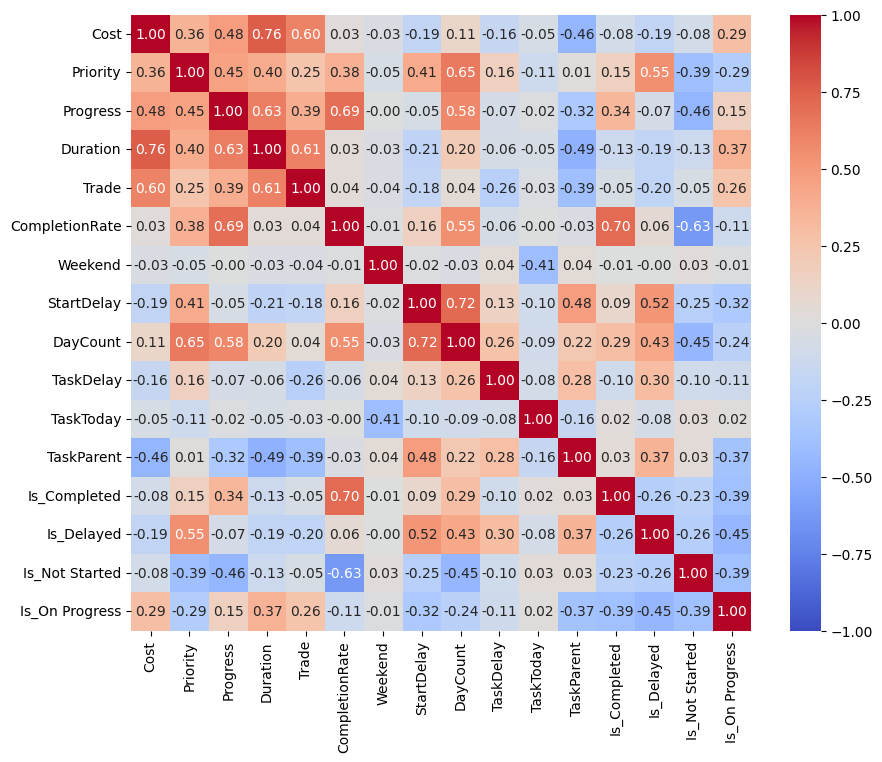

In [11]:
plt.figure(figsize=(10, 8))
sns.heatmap(tasks_df.corr(), vmin=-1, vmax=1, annot=True, fmt=".2f",cmap='coolwarm')

<Axes: >

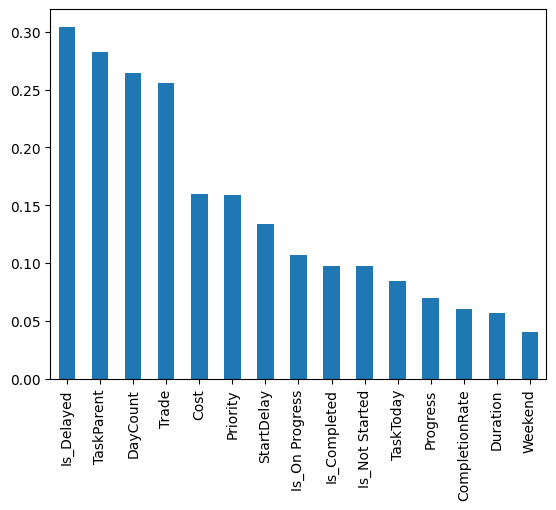

In [12]:
tasks_df.corr()['TaskDelay'].abs().sort_values(ascending=False).iloc[1:].plot(kind='bar')

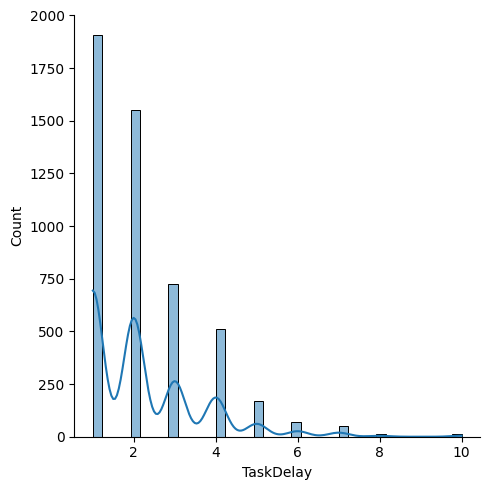

In [13]:
sns.displot(tasks_df['TaskDelay'], kde=True)

## Model Development

In [14]:
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, TheilSenRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor, BaggingRegressor, VotingRegressor, StackingRegressor

In [15]:
X = tasks_df.copy()
y = X.pop(target)

X_train = X[~X.index.isin(test_idx)]
y_train = y[~y.index.isin(test_idx)]
X_test = X[X.index.isin(test_idx)]
y_test = y[y.index.isin(test_idx)]

# Creating and training the decision tree regression model
model = DecisionTreeRegressor(max_depth=5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_pred)
print("Train MAE :", mae_train, " | Test MAE : ", mae_test)

Train MAE : 0.8298073363118537  | Test MAE :  0.8459540312425494


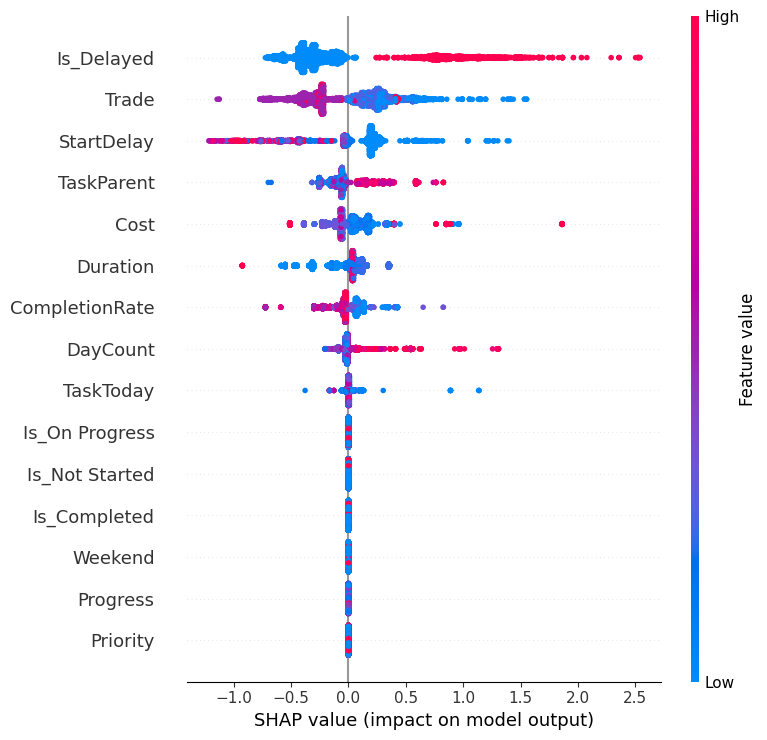

In [16]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)
shap.summary_plot(shap_values)

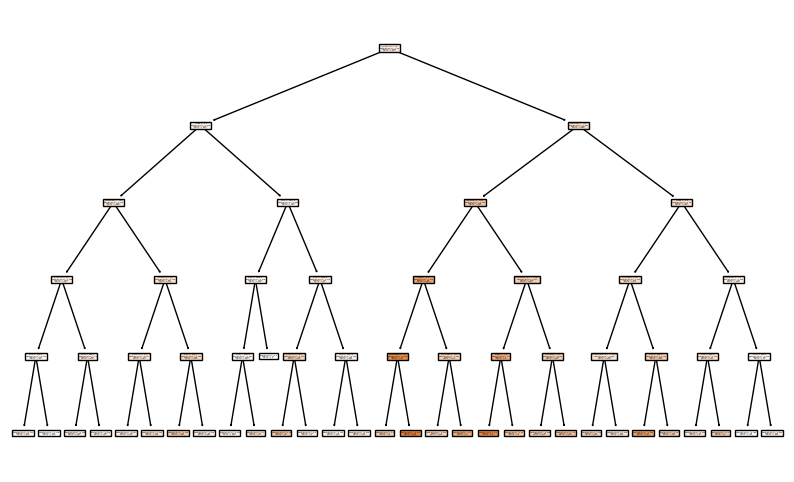

In [18]:
# Plot the decision tree
plt.figure(figsize=(10,6))
plot_tree(model, filled=True, feature_names=X.columns)
plt.show()

In [19]:
models = {
        "Linear Regression": LinearRegression(),
        "Ridge Regression": Ridge(),
        "Lasso Regression": Lasso(),
        "ElasticNet Regression": ElasticNet(),
        "SVR": SVR(),
        "Decision Tree": DecisionTreeRegressor(max_depth=5),
        "Random Forest": RandomForestRegressor(max_depth=5),
        "Extra Trees": ExtraTreesRegressor(max_depth=5),
        "Gradient Boosting": GradientBoostingRegressor(),
        "Bagging Regression": BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=5)),
        "AdaBoost Regression": AdaBoostRegressor(),
        "Bayesian Ridge Regression": BayesianRidge(),
        "Theil-Sen Regression": TheilSenRegressor()
    }

def evaluate_regression_models(X_train, y_train, X_test, y_test, models):    
    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        mae_train = mean_absolute_error(y_train, y_train_pred)
        mae_test = mean_absolute_error(y_test, y_test_pred)
        results.append({"Model": name, "Train MAE": mae_train, "Test MAE": mae_test})
    
    return pd.DataFrame(results)

results_df = evaluate_regression_models(X_train, y_train, X_test, y_test, models)
results_df.sort_values(by='Test MAE', inplace=True)

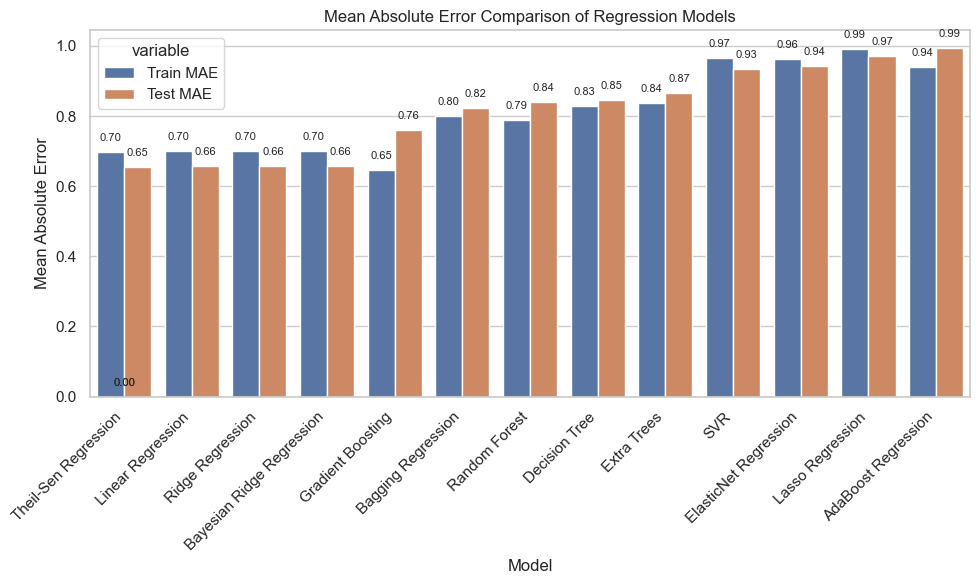

In [20]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=results_df.melt(id_vars="Model"), x="Model", y="value", hue="variable")
ax.set_title('Mean Absolute Error Comparison of Regression Models')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlabel('Model')
plt.xticks(rotation=45, ha='right')

# Adding value labels above each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points',
                fontsize=8)  # Adjust font size here

plt.tight_layout()
plt.show()

In [21]:
models_list = list(models.values())
voting_ensemble = VotingRegressor(estimators=[(name, model) for name, model in models.items()])
voting_ensemble.fit(X_train, y_train)

# Evaluate the voting ensemble
y_train_pred = voting_ensemble.predict(X_train)
y_test_pred = voting_ensemble.predict(X_test)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print("Voting Ensemble Train MAE:", mae_train)
print("Voting Ensemble Test MAE:", mae_test)

Voting Ensemble Train MAE: 0.7476983723140375
Voting Ensemble Test MAE: 0.7566788191878037


In [22]:
base_models = [(name, model) for name, model in models.items() if name != "Theil-Sen Regression"]
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=TheilSenRegressor())
stacking_regressor.fit(X_train, y_train)

y_train_pred = stacking_regressor.predict(X_train)
y_test_pred = stacking_regressor.predict(X_test)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print("Stacking Regressor Train MAE:", mae_train)
print("Stacking Regressor Test MAE:", mae_test)

Stacking Regressor Train MAE: 0.6638410850792156
Stacking Regressor Test MAE: 0.7428141703419264
